### EDA(Exploratory Data Analysis) of Power Trace files
The goal of this notebook is to go through all power trace values and get the average exponent value. This will be used to increase all power values so the CNN would struggle less and unlikely run into vanishing gradient problems.

### Essential imports
Rather than using Pandas, I decided to use a simple loop over all files with a line-read function.

Will use seaborn for visualization.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import re

## Helper Functions

In [2]:
''' 
Function that extracts all exponent values from a SINGLE power trace file
Input:
    1) filename: string; name of power trace file
Returns:
    1) avg_exponent: float; average exponent of all power trace values
'''
def extract_exponents_from_file(file_path):
    exponents = []
    with open(file_path, 'r') as f:
        next(f)
        for line in f:
            parts = line.strip().split()
            if len(parts) < 2:
                continue  # Skip lines with fewer than 2 columns
            value_str = parts[1]
            if 'e' not in value_str:
                print(f"Skipping non-scientific value '{value_str}' in {file_path}")
                continue
            try:
                exponent = int(value_str.split('e')[1])
                exponents.append(exponent)
            except ValueError:
                print(f"Invalid exponent format in '{value_str}' from {file_path}")
                continue
    return exponents

### Data Analysis

In [3]:
# Loop through all power trace files, create dictionary of avg exponent values
cwd = os.getcwd()
root_path = os.path.join(cwd, 'trace_files')
exp_results = defaultdict(list)
min_val = None
max_val = None

# exp_results: key = each dir, items = list of (sum(exponent), len(exponent)) tuples per file
for root, subfolders, files in os.walk(root_path):
    if files:
        print(f"Handling: {files}...")
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                temp = extract_exponents_from_file(file_path)
                if min_val is None or min_val > min(temp):
                    min_val = min(temp)
                if max_val is None or max_val < max(temp):
                    max_val = max(temp)
                exp_results[os.path.basename(root)].append((sum(temp), len(temp)))
                

Handling: ['sky_lin_s0_0.txt', 'sky_lin_s100_100.txt', 'sky_lin_s101_101.txt', 'sky_lin_s102_102.txt', 'sky_lin_s103_103.txt', 'sky_lin_s104_104.txt', 'sky_lin_s105_105.txt', 'sky_lin_s106_106.txt', 'sky_lin_s107_107.txt', 'sky_lin_s108_108.txt', 'sky_lin_s109_109.txt', 'sky_lin_s10_10.txt', 'sky_lin_s110_110.txt', 'sky_lin_s111_111.txt', 'sky_lin_s112_112.txt', 'sky_lin_s113_113.txt', 'sky_lin_s114_114.txt', 'sky_lin_s115_115.txt', 'sky_lin_s116_116.txt', 'sky_lin_s117_117.txt', 'sky_lin_s118_118.txt', 'sky_lin_s119_119.txt', 'sky_lin_s11_11.txt', 'sky_lin_s120_120.txt', 'sky_lin_s121_121.txt', 'sky_lin_s122_122.txt', 'sky_lin_s123_123.txt', 'sky_lin_s124_124.txt', 'sky_lin_s125_125.txt', 'sky_lin_s126_126.txt', 'sky_lin_s127_127.txt', 'sky_lin_s128_128.txt', 'sky_lin_s129_129.txt', 'sky_lin_s12_12.txt', 'sky_lin_s130_130.txt', 'sky_lin_s131_131.txt', 'sky_lin_s132_132.txt', 'sky_lin_s133_133.txt', 'sky_lin_s134_134.txt', 'sky_lin_s135_135.txt', 'sky_lin_s136_136.txt', 'sky_lin_s137_1

KeyboardInterrupt: 

In [ ]:
# key = dir, val = list of its avg exponent values
tot_exp_val = 0
tot_exp_len = 0
avg_results = {}
for k in exp_results.keys():
    dir_exp_val = 0
    dir_exp_len = 0
    for vals in exp_results[k]:
        dir_exp_val += vals[0]
        dir_exp_len += vals[1]
    avg_results[k] = np.float64(dir_exp_val / dir_exp_len)
    tot_exp_val += dir_exp_val
    tot_exp_len += dir_exp_len

for k, v in avg_results.items():
    print(f"Folder \"{k}\": {v}")
print(f"FINAL VALUE: {int(tot_exp_val/tot_exp_len)}")
print(f"SMALLEST VALUE: {min_val}")
print(f"LARGEST VALUE: {max_val}")

Folder "digital_1px_ff_p": -7.056290640564737
Folder "digital_1px_ff_x": -7.130820510572743
Folder "digital_1px_fs_p": -7.056290640564737
Folder "digital_1px_fs_r": -5.6707004119849485
Folder "digital_1px_fs_x": -7.130820510572743
Folder "digital_1px_ss_p": -7.056290640564737
Folder "digital_1px_ss_r": -7.402724044998938
Folder "digital_1px_ss_x": -7.130679287288054
Folder "digital_1px_tt_r": -7.044548891353862
FINAL VALUE: -6
SMALLEST VALUE: -12


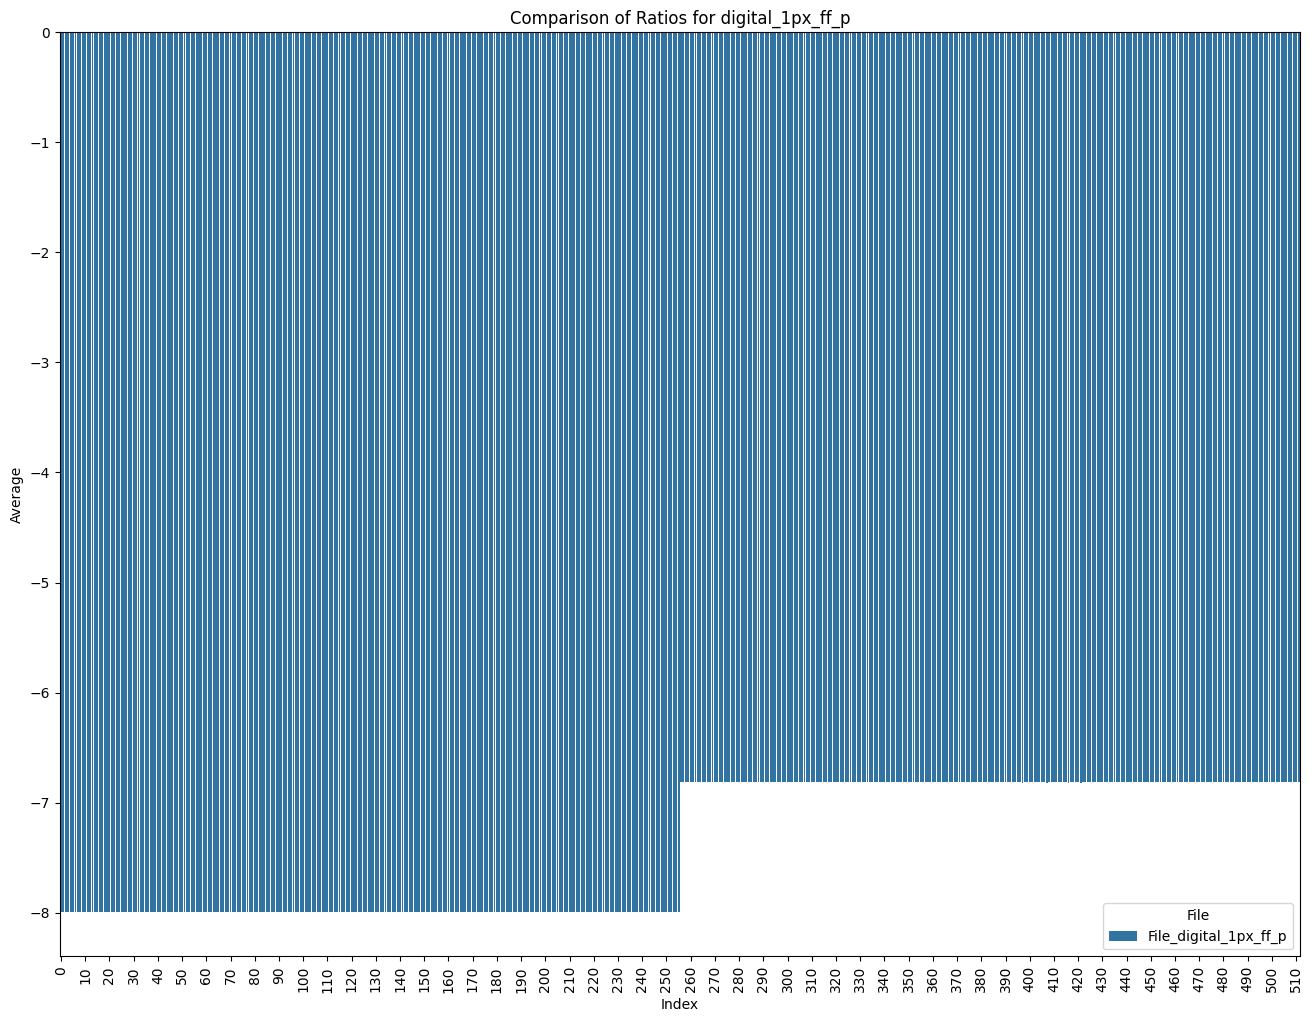

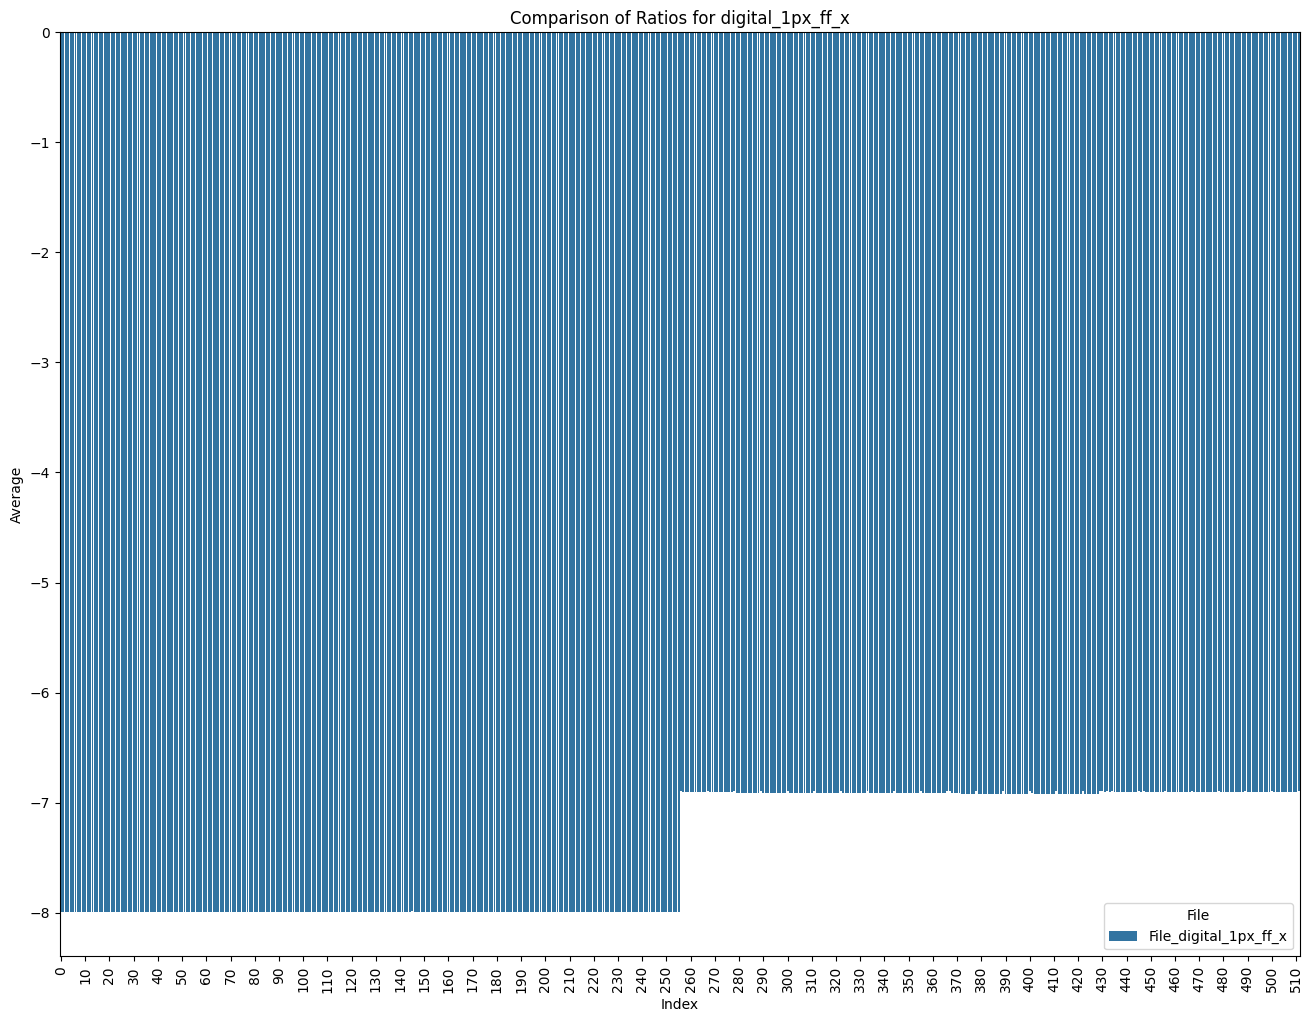

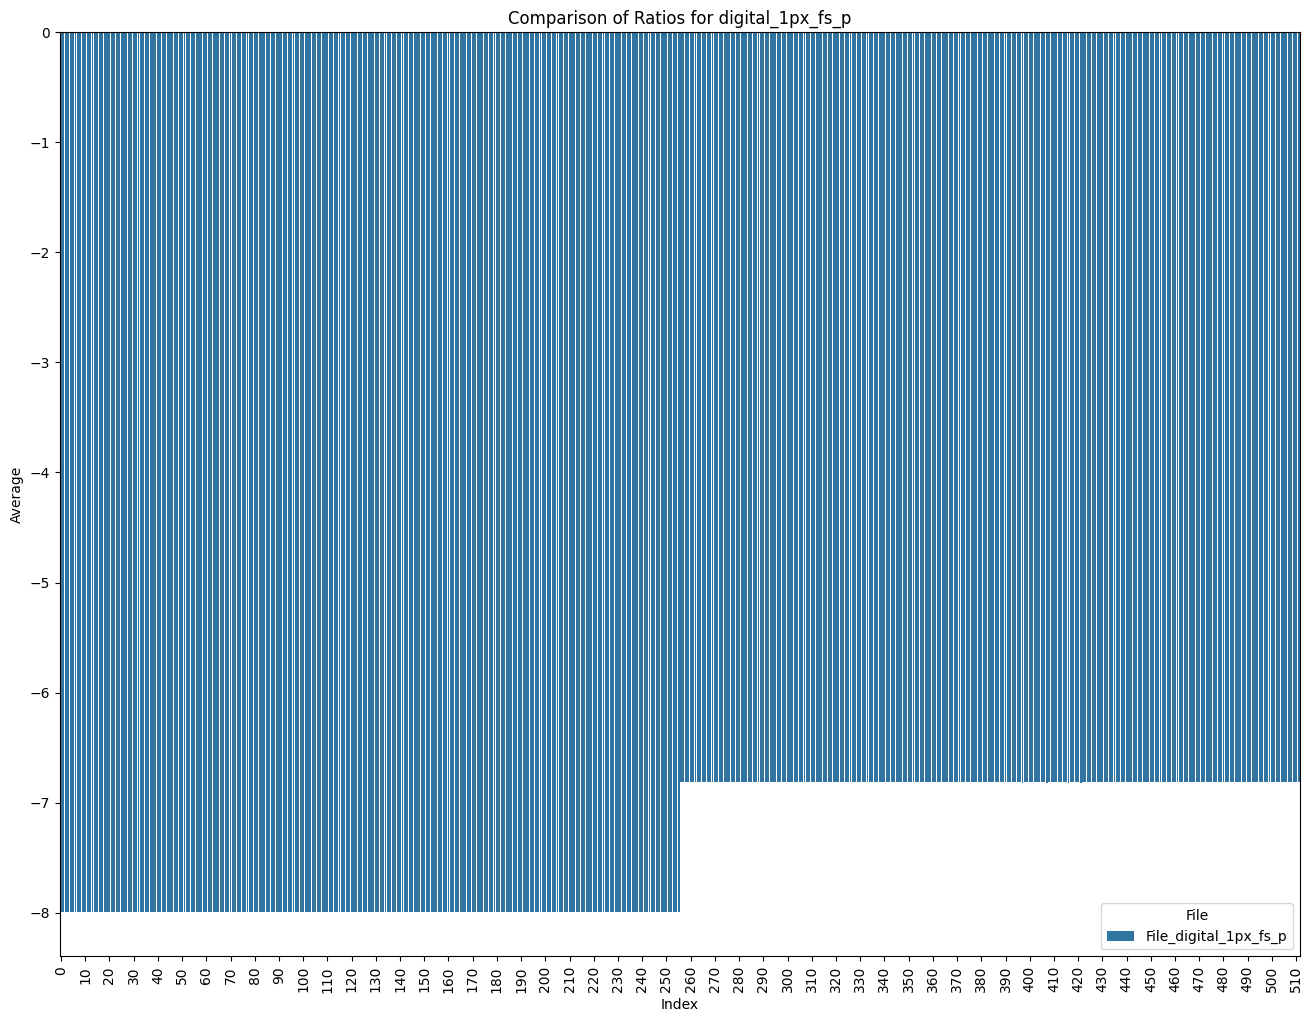

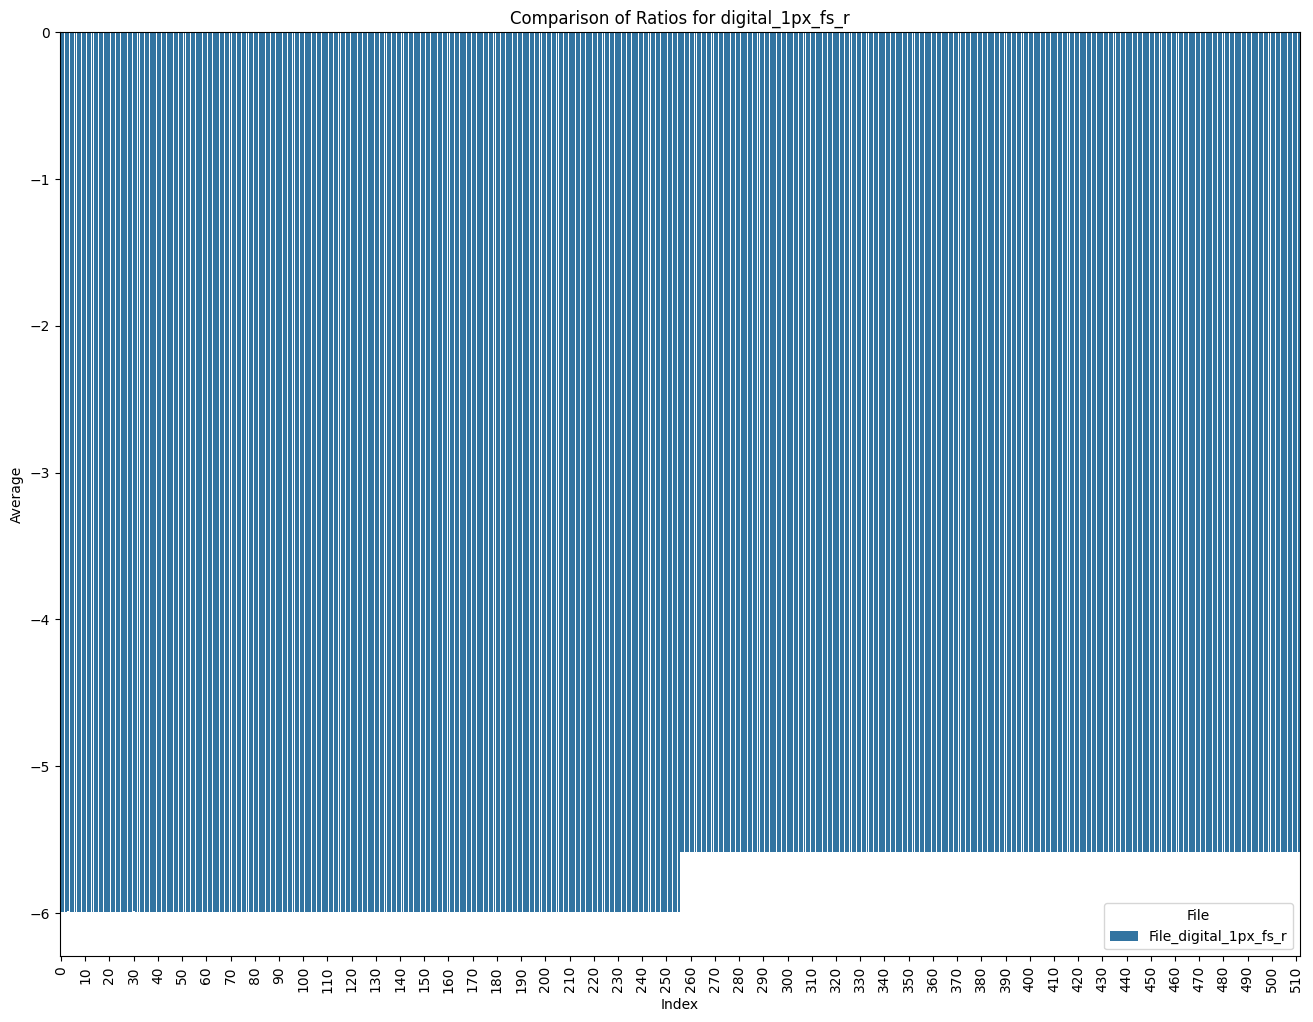

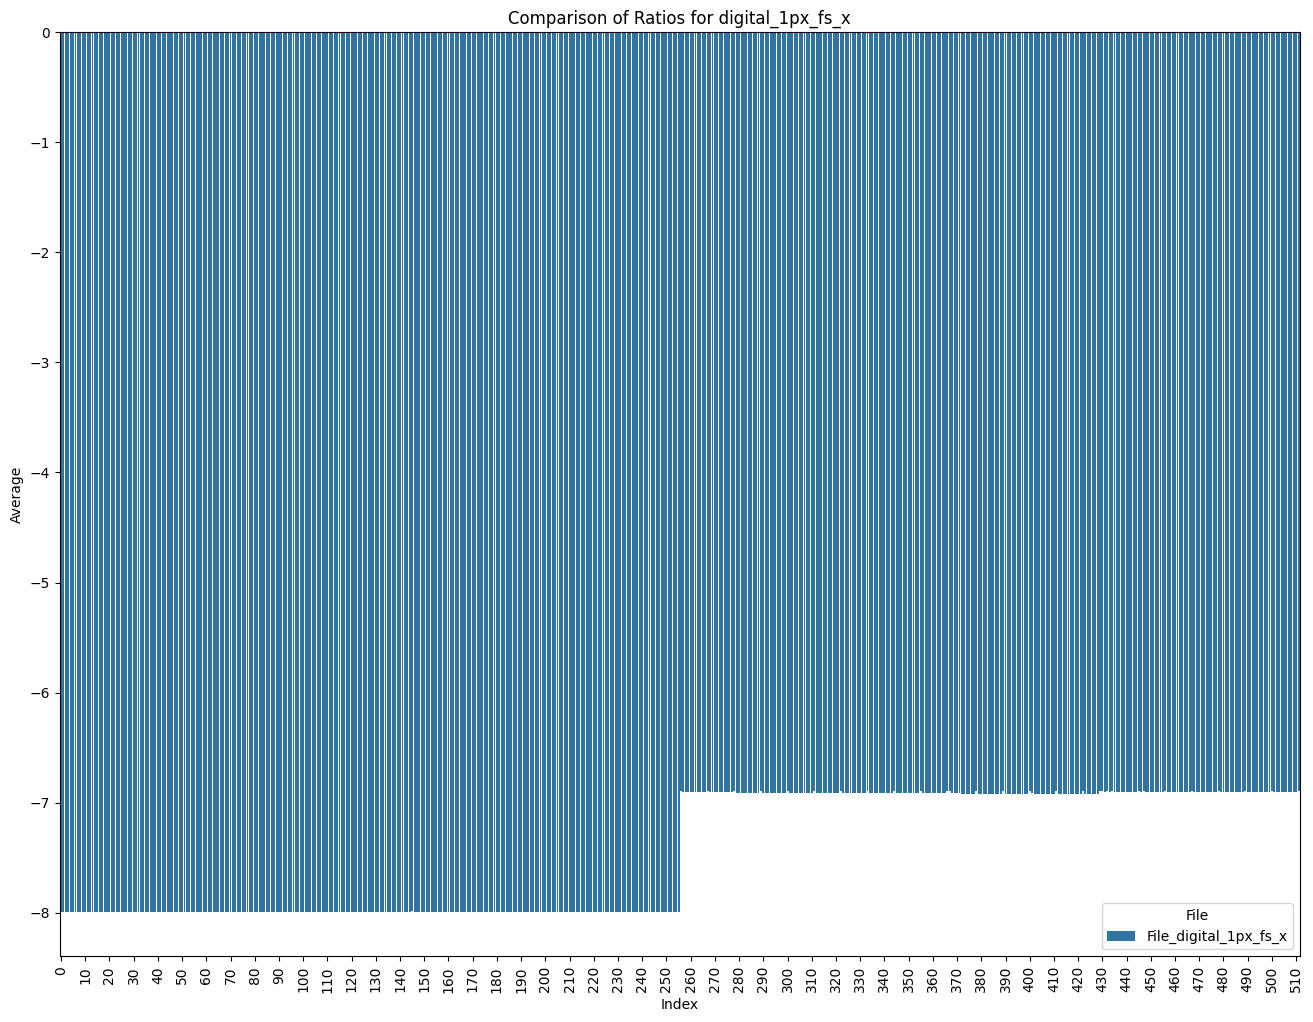

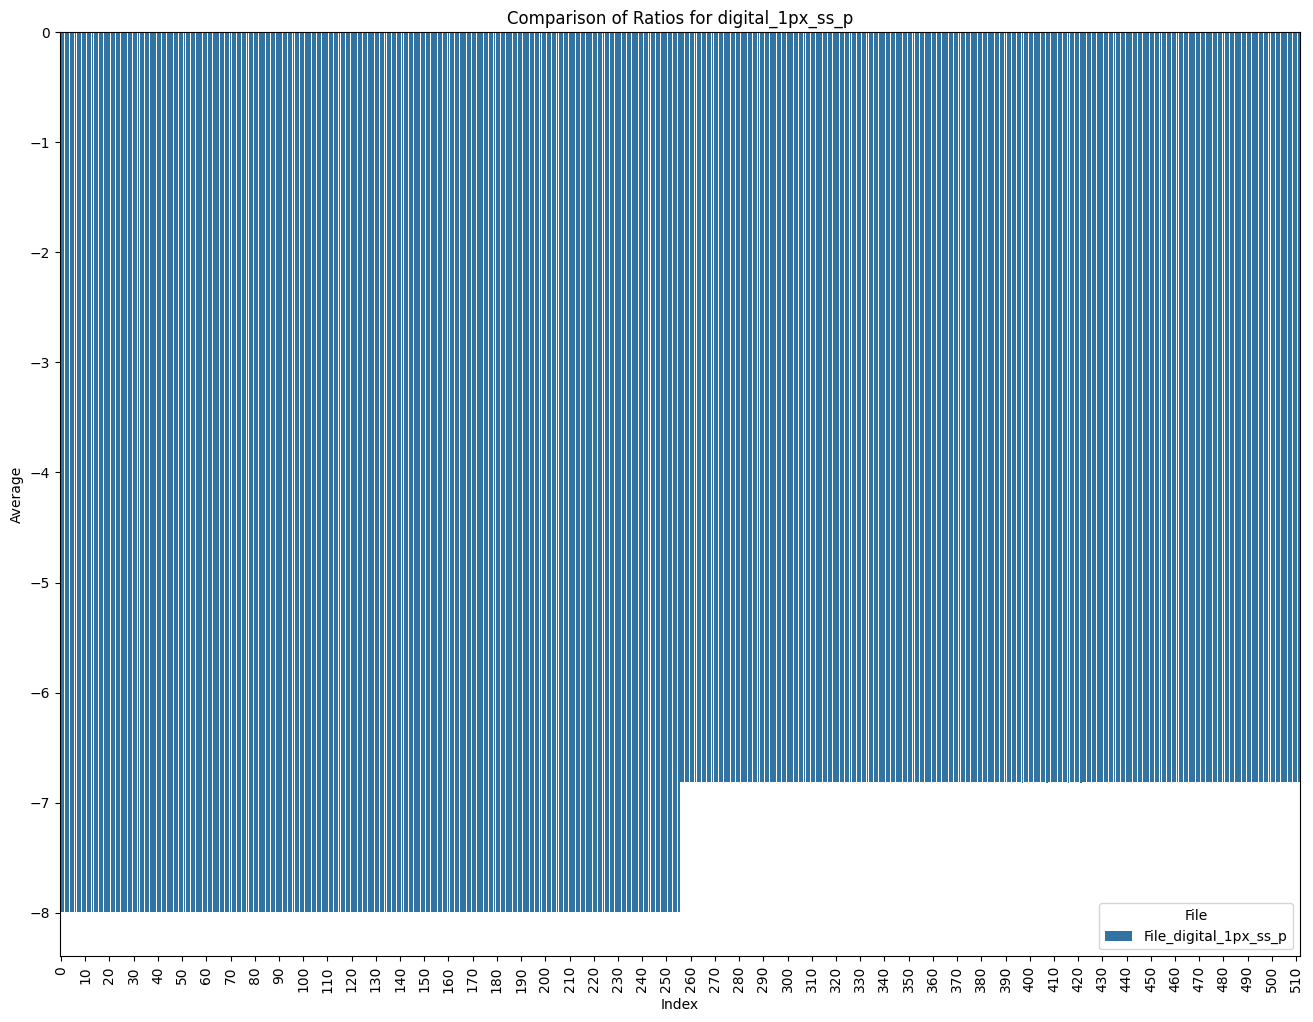

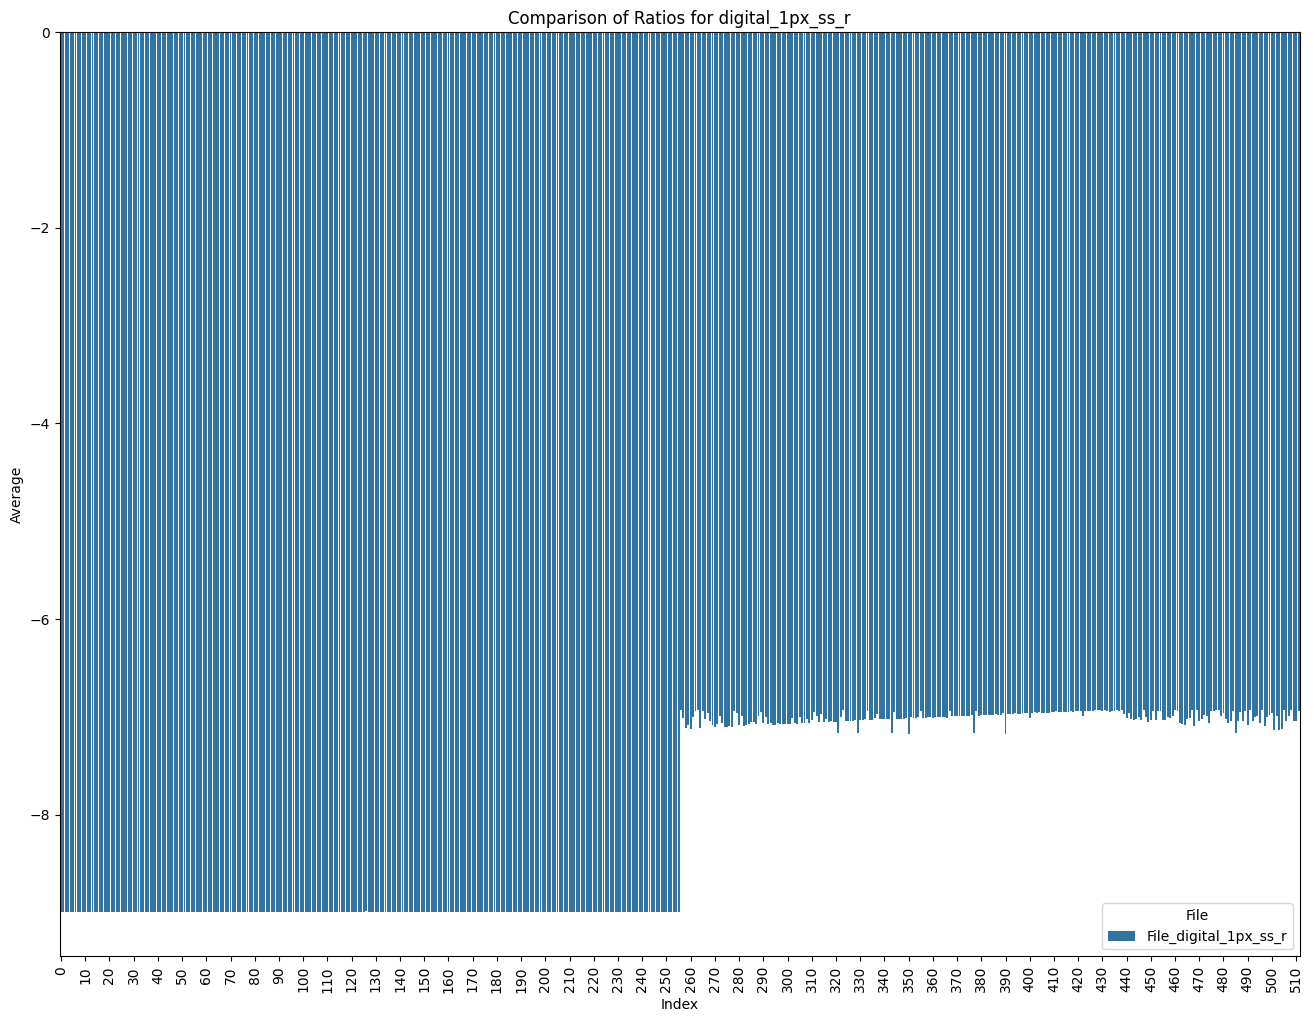

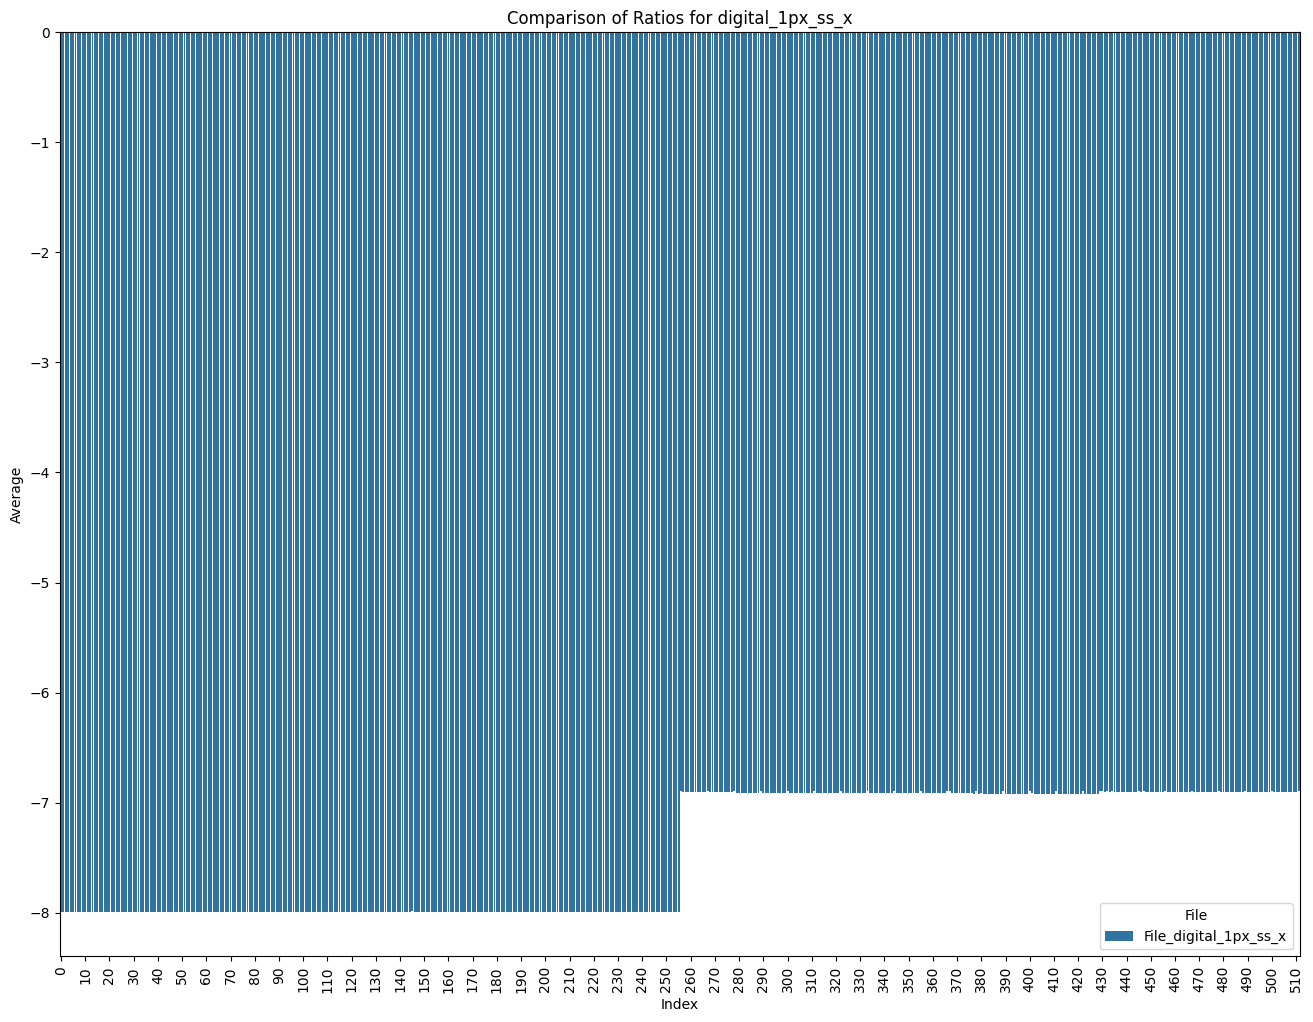

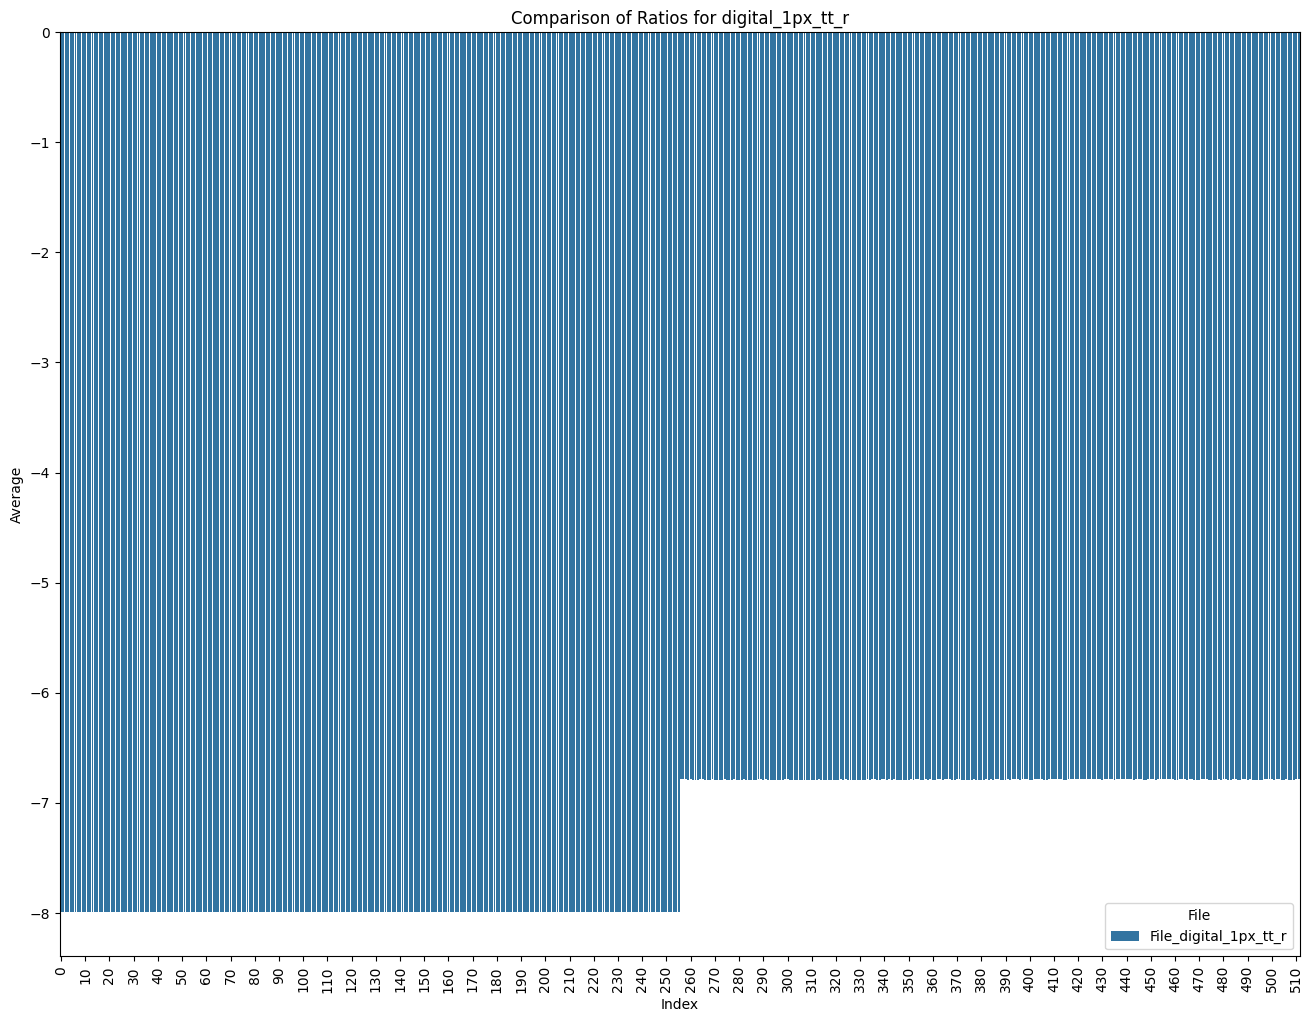

In [ ]:
def compute_avg(lst):
    return [x[0] / x[1] if x[1] != 0 else np.nan for x in lst]

# Create avg dict
avg_dict = {}

for k in exp_results.keys():
    avg_dict[k] = compute_avg(exp_results[k])

max_len = max(len(v) for k, v in avg_dict.items())

for k in avg_dict.keys():
    avg_dict[k].extend([np.nan] * (max_len - len(avg_dict[k])))

for k, v in avg_dict.items():
    # Create a DataFrame for each file's data
    df = pd.DataFrame({
        'Index': list(range(max_len)),
        f"File_{k}": v
    })

    # Melt the DataFrame for easier plotting with seaborn
    df_melted = df.melt(id_vars=["Index"], value_vars=[f"File_{k}"],
                        var_name="File", value_name="Ratio")

    # Create the barplot
    plt.figure(figsize=(16, 12))
    sns.barplot(x="Index", y="Ratio", hue="File", data=df_melted)
    plt.xticks(ticks=range(0, max_len, 10), rotation=90)

    # Customize the plot
    plt.title(f'Comparison of Ratios for {k}')
    plt.xlabel('Index')
    plt.ylabel('Average')
    plt.xticks(rotation=90)
    plt.legend(title='File')

    # Show the plot
    plt.show()